In [191]:
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

In [192]:
#defining the class MDN
class MDN_module(tf.keras.Model):
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        #self.h1=Dense(12,activation="relu",name="h1")
        #self.h2=Dense(8,activation="relu",name="h2")
        #self.h3=Dense(8,activation="relu",name="h3")
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        #x=self.h2(x)
        #x=self.h3(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [193]:
#nelu function, function to calculate the losses and evaluate them
no_parameters=3
components=1
#change this variable for x == 0 or x == -1
leftside=-1
#activation function
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))
#function to slice the returned list by the neural network
def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

#function that calculates the loss 
def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
    """ Evaluate the model to get the loss by calculating the mle instead of fitting the model
    """
    indices_1 = [i for i, x in enumerate(x_test) if x == 1]
    #changing x to -1
    indices_0 = [i for i, x in enumerate(x_test) if x == leftside]
    mu_0=np.mean(y_test[indices_0])
    mu_1=np.mean(y_test[indices_1])
    sigma_0=np.std(y_test[indices_0])
    sigma_1=np.std(y_test[indices_1])
    y_mean=np.zeros((len(y_test),1))
    y_mean[indices_1]=mu_1
    y_mean[indices_0]=mu_0
    y_std=np.zeros((len(y_test),1))
    y_std[indices_1]=sigma_1
    y_std[indices_0]=sigma_0
    alpha=np.ones((len(y_mean),1))
    return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [13]:
#compute the losses including mle 
def compute_loss(P,Q,mle=False):
    #Compute the loss for the given pair
    
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        #return np.array(nlcor.nlcor(P,Q)[0])[0]
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [199]:
#return the predicted y 
def compute_loss_y_pred(P,Q,mle=False):
    """ Computes the model prediction for a given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        indices_0 = [i for i, x in enumerate(P) if x == leftside]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [200]:
#used in L->A and L->B testing 
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else: 
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [45]:
# L = np.random.binomial(1,0.5,1000)  
# A=6*L + np.random.normal(0,1,1000)
# B=np.empty([1000,])
# B[L==1]=-3*(A[L==1]-6)*(A[L==1]-6)+np.random.normal(0,1,len(A[L==1]))+10
# B[L==0]=3*(A[L==0])*(A[L==0])+np.random.normal(0,1,len(A[L==0]))-24

In [16]:
A_test,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B)
print(sum(abs(y_pred_zeros[:,1]-y_pred_ones[:,1]))/1000)

21.473929004669188


In [202]:
# plt.scatter(A,B)
# plt.scatter(A_test,y_pred_ones[:,1])
# plt.scatter(A_test,y_pred_zeros[:,1])

In [18]:
B_strat=stratifydata(L,B)
A_test,y_ones,y_zeros=compute_third_testloss(L,A,B_strat)
print(sum(abs(y_zeros[:,1]-y_ones[:,1]))/1000)

31.08948091125488


In [201]:
# plt.scatter(A,B_strat)
# plt.scatter(A_test,y_ones[:,1])
# plt.scatter(A_test,y_zeros[:,1])

In [198]:
#change this to read the files 
link="/data/users/cs20s037/CITNonLinear/LinearDifferentvalues/testing_writingvalues_diff_variance.txt"
number_of_samples=121

In [197]:

fo=open(link, "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,number_of_samples):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [9]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(i < original for i in loss_list)/len(loss_list)
    
    

In [102]:
#function to stratify the data
def stratifydata(L,B):
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == leftside]
    B_dist_temp=np.zeros(len(B))
    mod_indices_1=random.sample(indices_1,len(indices_1))
    for i in range(len(indices_1)):
        B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

    mod_indices_0=random.sample(indices_0,len(indices_0))
    for i in range(len(indices_0)):
        B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
    return B_dist_temp
    

In [103]:
def compute_third_testloss(L,A,B):
    opt = tf.optimizers.Adam(1e-2)
    mdn_PQ = MDN_module()
    mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
##changing epochs didnt make much difference
    mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),y=np.array(B).T,epochs=100,batch_size=64,verbose=0)
#mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
    #withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
    L_ones=np.ones((L.shape))
    #print(L_ones)
    L_zeros=np.zeros((L.shape))
    #print(sum(abs(y_pred_zeros[:,1]-y_pred_ones[:,1]))/1000)
    #print(min(A))
    #print(max(A))
    A_test=A
    y_pred_ones= mdn_PQ.predict(np.concatenate([L_ones.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
    y_pred_zeros= mdn_PQ.predict(np.concatenate([L_zeros.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
    #y_pred = mdn_PQ.predict(A)
    return [A_test,y_pred_ones,y_pred_zeros]
    #print(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000)
    #alpha,mu,sigma = slice_parameter_vectors(y_pred)
    

In [104]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == leftside]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
        _,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B_dist_temp)
        
        loss.append(abs(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000))
    return loss

In [15]:
for i in range(j,j+n): 
    A=np.array(dataset_linear[i][1])
    B=np.array(dataset_linear[i][2])
    L=np.array(dataset_linear[i][0])
    shuffles=100
    A_shuffle=np.copy(A)
    B_shuffle=np.copy(B)
    #print("Original",B_shuffle)
    loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
    loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
    loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
    true_LA=compute_loss(L,A,True)
    true_LB=compute_loss(L,B,True)
    #true_LBresidual=calculate_difference(L,A,B)
    #loss_list_Bresidual,true_LBresidual=calculateLshuffle(L,A,B,shuffles)
    _,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B)
    true_LBresidual=abs(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000)
    LA_p=calculate_pvalue(true_LA,loss_list_LA)
    LB_p=calculate_pvalue(true_LB,loss_list_LB)
    AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
    
    f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #f.write(str(indices[i])+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #pickle_items=[loss_list_LA,loss_list_LB,loss_list_Bresidual,true_LA,true_LB,true_LBresidual,LA_p,LB_p,AB_p]
    #file_name=str(dataset_names[i])+".pkl"
    #open_file = open("./DLresultspickle1000shuffle/"+file_name, "wb")
    #pickle.dump(pickle_items, open_file)
    #open_file.close()

NameError: name 'j' is not defined

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR

In [64]:
regressor = SVR(kernel = 'rbf')

In [123]:
i=99

In [124]:
A=np.array(dataset_linear[i][1])
B=np.array(dataset_linear[i][2])
L=np.array(dataset_linear[i][0])

Text(0.5, 1.0, 'A vs B')

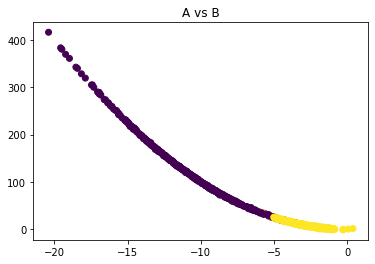

In [181]:
plt.scatter(A,B,c=L)
plt.title("A vs B")

array([-3.59664187e-01,  3.16186368e-01,  7.57827510e-01, -1.02370691e-01,
        2.45284639e-01,  2.49399671e+00, -6.99442929e-01, -2.90473451e-01,
        5.57190611e-01, -2.96041077e-01,  4.93367650e-01, -9.56804529e-01,
        8.67577109e-01,  5.34851042e-01,  1.44068245e-01,  6.07658887e-01,
       -6.78125985e-01, -2.36231909e-01,  3.04266831e-01,  1.26922827e-01,
       -2.19167665e+00,  5.96956969e-02,  1.83807274e-01,  4.18501525e-01,
        6.05344728e-01, -1.87150747e-01, -1.14344877e-01,  2.87419076e-01,
        3.96039989e-01,  1.07970888e+00,  3.67040081e-01,  6.40716474e-01,
        1.14805479e-01, -7.98902692e-01,  1.24918163e+00, -1.62147615e+00,
        7.81526424e-01,  1.22726184e+00, -1.19559152e+00, -1.94683841e+00,
       -2.70911903e-01,  4.46149356e-01,  6.40654090e-02,  2.11707388e-01,
       -3.35647629e-01,  1.36404583e+00,  1.02356528e-01,  7.75753667e-01,
        1.05922100e+00, -5.68367737e-01,  9.86299527e-01, -1.41367422e+00,
        2.78018899e-01,  

In [127]:
X=np.vstack((L,A)).T

In [163]:
X

array([[ 1.        , -3.19530717],
       [ 1.        , -3.47048828],
       [ 1.        , -4.97671474],
       ...,
       [ 1.        , -2.89152777],
       [-1.        , -8.81467322],
       [ 1.        , -1.95874434]])

In [156]:
L_ones=np.ones((L.shape))
#print(L_ones)
L_minus=np.ones((L.shape))*leftside

In [159]:
X_zero=np.vstack((L_minus,A)).T

In [168]:
X_zero

array([[-1.        , -3.19530717],
       [-1.        , -3.47048828],
       [-1.        , -4.97671474],
       ...,
       [-1.        , -2.89152777],
       [-1.        , -8.81467322],
       [-1.        , -1.95874434]])

In [161]:
X_one=np.vstack((L_ones,A)).T

In [169]:
X_one

array([[ 1.        , -3.19530717],
       [ 1.        , -3.47048828],
       [ 1.        , -4.97671474],
       ...,
       [ 1.        , -2.89152777],
       [ 1.        , -8.81467322],
       [ 1.        , -1.95874434]])

In [184]:
regressor.fit(X, B_strat)

SVR()

In [27]:
y_pred = regressor.predict([[0,2]])

In [28]:
y_pred

array([0.25351959])

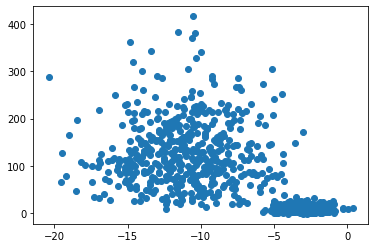

In [165]:
plt.scatter(A,B_strat)

In [141]:
B_strat=stratifydata(L,B)

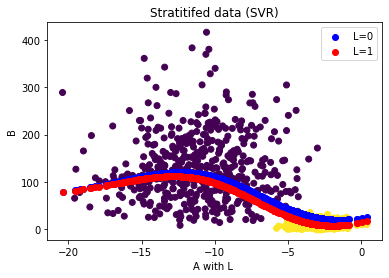

In [190]:
plt.scatter(A, B_strat,c=L)
plt.scatter(A, regressor.predict(X_zero), color = 'blue',label='L=0')
plt.scatter(A,regressor.predict(X_one),color='red',label='L=1')
plt.title('Stratitifed data (SVR)')
plt.xlabel('A with L ')
plt.ylabel('B')
plt.legend()
plt.show()

In [ ]:
# Predicting the target values of the test set
y_pred = model.predict(X)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("\nRMSE: ", rmse)